# Monte Carlo simulation of protein-protein interactions

## Methodology

In this notebook we explore the interaction between lactoferrin and a β-lactoglobulin dimer using Metropolis-Hastings Monte Carlo (MC) simulations. The two protein structures are kept rigid and coarse grained so that each amino acid is represented by a single bead of size $\sigma_i$. These beads interact with a combined Lennard-Jones and Debye-Hückel potential to account for short-range repulsion and attraction, as well as electrostatic interactions in an aqueous electrolyte solution.
The ionization state of each amino acid is _fluctuating_ according to its p$K_a$-value and solution pH; this is done using a _constant pH ensemble_.
The MC system energy function is:

$$
U = \sum_i^{N-1}\sum_{j=i+1}^{N} \left \{ 4\epsilon_{ij} \left [ \left( \frac{\sigma_{ij}}{r_{ij}} \right )^{12}  - \left( \frac{\sigma_{ij}}{r_{ij}} \right )^{6}\right ]
  + k_BT \frac{\lambda_Bz_iz_j}{r_{ij}} \right \}
  + \mathcal{B}(R)
$$

where
$\lambda_B=7$ Å is the Bjerrum length,
$z$ are residue charges,
$r$ the inter-residue separation,
$\epsilon=0.05~k_BT$ the Lennard-Jones interaction strength.
The final term will be explaned below.

The mass centers of the two rotating proteins are fixed on a line along which they are allowed to translate. In addition to rotational and translation MC moves, move attempts are also performed to (de-)protonate acidic and basic residues.
During simulation, we sample the radial distribution function, $g(R)$, which is related to the angularly averaged _potential of mean force_, $w(R) = -k_BT \ln g(R) + w_0$, where the reference state $w_0$ is chosen such that $w(R)\rightarrow 0$ for large $R$.

### Simulation bias

The two proteins are oppositely charged and at salt concentrations, $c_s$, they _strongly associate_ due to electrostatic attraction.
Because of this, only short separations are sampled and almost no sampling is done at large $R$.
This makes it very difficult to determine $w_0$ within reasonable simulation times.
As an example, if the interaction free energy is -16 $k_BT$ when the proteins are in contact, then the probability of observing them at long separations is roughly $e^{-16}\sim 10^{-7}$.
To promote sampling at large separations, we therefore add a _bias potential_ to the MC energy function:

$$
\mathcal{B}(R) = -k_BT\lambda_B Z_1 Z_2 \left ( \frac{\sinh(\kappa a)}{\kappa a} \right )^2
              \left [
              \frac{1 + \kappa a \coth(\kappa a)}{R} - \frac{\kappa}{2}
              \right ] e^{-\kappa R}
$$

The observed potential of mean force, $w^{\prime}(R)$ is now _biased_ and unphysical, but since $\mathcal{B}(R)$ is isotropic and added along the mass-center separation, $R$, we can simply unbias by subtraction to recover the true free energy:

$$
w(R) = w^{\prime}(R) - \mathcal{B}(R)
$$

The choice of $\mathcal{B}(R)$ is arbitrary, but most efficient if $w^{\prime}(R)$ is as flat as possible, whereby all distances are sampled. The above function is the monopole-monopole interaction in an electrolyte solution from Sogame-Ise theory (https://dx.doi.org/10.1073/pnas.95.26.15169), and effectively removes a large part of the electrostatic attraction (note the negative sign)..
$Z_1$ and $Z_2$ denote the average protein charges and $a=36$ Å is an effective diameter, chosen such that $w^{\prime}(R)$ is reasonably flat over a large range of ionic strengths.

### Parallel tempering

Is not available for Grand Canonical simulations yet (or it is at least very experimental in Faunus)

## Setup simulation conditions

This sets up simulations conditions which is here a single pH-value and multiple salt concentrations.
The data is collected into a Pandas data-frame.

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path, os, sys, glob, json, copy
from math import log, exp, sqrt, sinh, tanh, isnan # coth(x) = 1/tanh(x)
from jinja2 import Template
from itertools import product
import ruamel_yaml as yaml
from io import StringIO 
from scipy.stats import binned_statistic

faunusdir = '/Users/mikael/github/faunus/' # point to Faunus from ~20 December 2022 or later

pH_range = [5.5]
salt_range = np.array([0.005, 0.01, 0.05]) # mol/l

df = pd.DataFrame(product(pH_range, salt_range), columns=['pH', 'Cs'])
df.T

,0,1,2
pH,5.500,5.50,5.50
Cs,0.005,0.01,0.05


## Create simulation input files

Here we create input files where each salt concentration has its own directory.
The input files are created from `template.yml` using Jinja2.

In [3]:
def makeFaunusInput(outfile, **kwargs):
    ''' generate faunus input file from Jinja2 template '''
    with open('template.yml', 'r') as file: # this is the template file
        template = Template(file.read())
        Cs = kwargs['Cs']
        os.makedirs(f'Cs{Cs}', exist_ok=True)
        with open(f'Cs{Cs}/' + outfile, 'w') as f:   # open a new faunus input file
            inputstr = template.render(kwargs)
            d = yaml.safe_load(StringIO(inputstr)) # convert string to stream
            f.write(yaml.dump(d))

for idx, row in df.iterrows():
    makeFaunusInput('eq.yml', Cs=row.Cs, pH=row.pH, micro=500, mpi=idx)  # equilibration
    makeFaunusInput('input.yml', Cs=row.Cs, pH=row.pH, micro=40000, mpi=idx) # production

### Run simulations

This loops over the input parameters which are here merely salt concentrations. This currently runs completely serial, so either change this, or start the simulations from a terminal.

In [9]:
for idx, row in df.iterrows():
    %cd Cs{row.Cs}
    # Short equilibration run
    !yason.py eq.yml | /Users/mikael/github/faunus/faunus --nobar --nofun -v 2
    # Long production run
    #!yason.py input.yml | /Users/mikael/github/faunus/faunus --state state.json --nobar --nofun -v 2
    %cd -q ..
print('Done.')

/Users/mikael/github/SI-betalac-lactoferrin/explicit_ions/Cs0.005
/Users/mikael/github/SI-betalac-lactoferrin/explicit_ions
/Users/mikael/github/SI-betalac-lactoferrin/explicit_ions/Cs0.01
/Users/mikael/github/SI-betalac-lactoferrin/explicit_ions
/Users/mikael/github/SI-betalac-lactoferrin/explicit_ions/Cs0.05
/Users/mikael/github/SI-betalac-lactoferrin/explicit_ions


## Pre-load simulation output

In this step we load simulation output into the Pandas dataframe.
This is merely for convenience.

In [10]:
df['rdf'] = [np.loadtxt(f'Cs{row.Cs}/rdf.dat', unpack=True) for _, row in df.iterrows()]
df['json_output'] = [json.load(open(f'Cs{row.Cs}/out.json')) for _, row in df.iterrows()]
df['multipoles'] = [np.loadtxt(f'Cs{row.Cs}/multipole.dat', unpack=True) for _, row in df.iterrows()]
df

,pH,Cs,rdf,json_output,multipoles
0,5.5,0.005,"[[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...",{'analysis': [{'virtualtranslate': {'dL': 0.05...,"[[61.0, 63.0, 65.25, 70.75, 72.25, 74.0, 74.25..."
1,5.5,0.010,"[[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...",{'analysis': [{'virtualtranslate': {'dL': 0.05...,"[[61.0, 61.25, 61.75, 62.75, 63.0, 63.25, 63.5..."
2,5.5,0.050,"[[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...",{'analysis': [{'virtualtranslate': {'dL': 0.05...,"[[54.0, 54.25, 54.5, 54.75, 55.0, 55.25, 55.75..."


## Plot potential of mean force, $w(R)$

For each condition, this:
1. Loads the sampled radial distribution function
2. Converts it to a free energy, $w^{\prime}(R)$
3. Shifts $w^{\prime}(R)$ to zero at large separations (finds $w_0$)
4. Unbias to obtain $w(R)$
5. Plot

/var/folders/q8/__l974fj6tv9gwyvvzb0w8x80000gn/T/ipykernel_92092/2186272574.py:22: RuntimeWarning: Mean of empty slice.
  w0 = w[(R > 95) & (R<100)].mean() # reference state (kT)
/Users/mikael/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


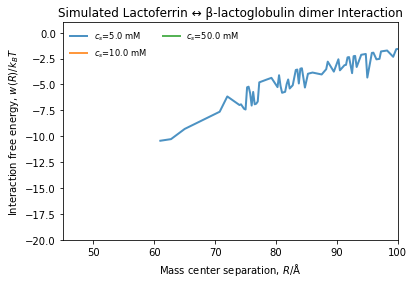

In [11]:
def getSIpotential(r, jsonoutput):
    '''
    Returns negative of a Sogame-Isa (SI) monopole-monopole potential
    See for example Eq. 4 in doi:10.1073/pnas.95.26.15169 
    '''
    bjerrum_length = 7 # water at 300 Kelvin. Units of Å
    Z1 = jsonoutput['analysis'][7]['multipole']['molecules']['betalac']['Z']
    Z2 = jsonoutput['analysis'][7]['multipole']['molecules']['lactoferrin']['Z']

    a = 36 # effective size (Å)
    kappa = sqrt(row.Cs) / 3.04 # inverse Debye length (1/Å)
    ka = kappa * a
    scale = sinh(ka) / (ka)
    return -bjerrum_length * Z1 * Z2 * scale**2 * ((1 + ka * 1/tanh(ka)) / r - kappa/2 ) * np.exp(-kappa*r)

for idx, row in df.iterrows():
    R, rdf = row.rdf
    is_sampled = rdf != 0             # ignore distances with no sampling
    R = R[is_sampled]                 # mass-center separation (Å)
    rdf = rdf[is_sampled]             # radial distribution function
    w = -np.log(rdf)                  # potential of mean force (kT)
    w0 = w[(R > 95) & (R<100)].mean() # reference state (kT)
    w = w - w0                        # shift to zero at large separation
    bias = getSIpotential(R, row.json_output)
    plt.plot(R, w - bias, label=f'$c_s$={row.Cs * 1000} mM', alpha=0.8, lw=2)

plt.xlim(45, 100)
plt.ylim(-20, 1)
plt.title('Simulated Lactoferrin ↔︎ β-lactoglobulin dimer Interaction')
plt.ylabel('Interaction free energy, $w(R) / k_BT$')
plt.xlabel('Mass center separation, $R$/Å')
plt.legend(loc=0, fontsize='small', frameon=False, ncol=2)
plt.show()

### Alternative $w(R)$ calculation using virtial translation moves

In this section we obtain the potential of mean force using [_virtual translation moves_ (VTM)](https://faunus.readthedocs.io/en/latest/_docs/analysis.html#virtual-translate-move).
By _virtual_ we mean that the system is momentarily perturbed, so that one of the proteins is slightly displaced along the mass-center connection vector.
Using linear perturbation theory, this can be used to obtain the _force_, $f(R)$ which can be numerically integrated to yield the interaction free energy, $w^{\prime}(R)$.
Exactly as in the previous section, we need to unbias to get the true $w(R)$.

Results from the virtual translation move are stored as a function of MC steps (in `vt.dat.gz`), and prior to analysis we need to bin into distinct $R$ values.
This is done by the `getForces()` function. The bias energy, stored in `energy.dat.gz`, is obtained similarly.

#### Discussion

There are small differences compared to the previous histogram method. This is likely due to the fact that we bin differently and VTM data is hence smoothed slightly.

/var/folders/q8/__l974fj6tv9gwyvvzb0w8x80000gn/T/ipykernel_92092/3503725067.py:23: RuntimeWarning: Mean of empty slice.
  w0 = w[(R > 95) & (R<100)].mean()


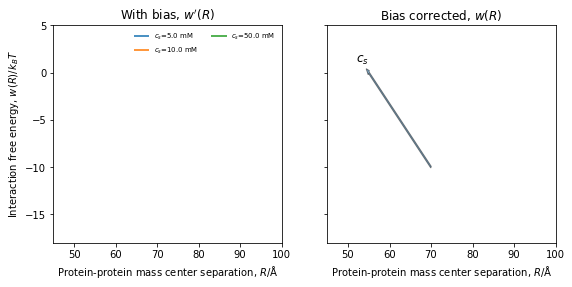

In [13]:
def getForces(Rfile, virtual_translate_file, bins):
    ''' bin average force as a function of R '''
    R = np.loadtxt(Rfile, usecols=[1])
    steps, dL, du, force = np.loadtxt(virtual_translate_file, unpack=True, skiprows=1)
    means, edges, bins = binned_statistic(R, np.exp(-du), 'mean', bins)
    return edges[1:], (np.log(means) / dL[0])

def getBias(Rfile, energy_file, bins):
    ''' bin bias as a function of R '''
    x = np.loadtxt(Rfile, usecols=[1])
    y = np.loadtxt(energy_file, usecols=[3]) # bias energy is in column [3]
    means, edges, bins = binned_statistic(x, y, 'mean', bins)
    return (edges[:-1] + edges[1:]) / 2, means

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(9,4)

for idx, row in df.iterrows():
    Cs = row.Cs
    R, force = getForces(f'Cs{Cs}/R.dat.gz', f'Cs{Cs}/vt.dat.gz', 100)
    R, bias = getBias(f'Cs{Cs}/R.dat.gz', f'Cs{Cs}/energy.dat.gz', 100)
    w = -np.cumsum(force)*np.diff(R)[:-2].mean()
    w0 = w[(R > 95) & (R<100)].mean()
    w = w - w0
    ax1.plot(R, w, label=f'$c_s$={row.Cs * 1000} mM', alpha=0.8, lw=2)
    ax2.plot(R, w - bias)

ax1.set_title(r'With bias, $w^{\prime}(R)$')
ax2.set_title(r'Bias corrected, $w(R)$')
plt.xlim(45, 100)
plt.ylim(-18, 5)
ax1.legend(frameon=False, loc=0, fontsize='x-small', ncol=2)
#fig.suptitle('Simulated Lactoferrin ↔︎ β-lactoglobulin dimer Interaction')
ax1.set_ylabel('Interaction free energy, $w(R) / k_BT$')
ax1.set_xlabel('Protein-protein mass center separation, $R$/Å')
ax2.set_xlabel('Protein-protein mass center separation, $R$/Å')
ax2.arrow(x=70, y=-10, dx=-15, dy=10, width=.2, alpha=0.5, head_width=0.5)
ax2.annotate(r'$c_s$', xy = (52, 1.1), fontsize='large')
plt.savefig("free_energy_vs_salt.pdf", bbox_inches='tight')
plt.show()

## Free energy difference in the minimum

In this section we investigate how the simulated free energy minimum shifts with salt concentration. This is then compared to how the measured (ITC) binding constant shifts with salt concentration. Both the measured and simulated data are reported relative to a reference ($*$) salt concentration $c_s^*=15$ mM. We thus report on
$$
\Delta \Delta G_{exp} = \Delta G_{exp} - \Delta G_{exp}^* = -\ln \frac{ K_a} { K_a^*}
$$
and
$$
\Delta \Delta G_{sim} \approx w(R_{min}) - w^*(R_{min})
$$
where $R_{min}$=56 Å.

In [ ]:
rmin = 56.0 # approx. distance of free energy minimum
wmin = []
dG_sim = ([], []) # Cs and minimum free energy (kT)
for idx, row in df.iterrows():
    Cs = row.Cs
    R, force = getForces(f'Cs{Cs}/R.dat.gz', f'Cs{Cs}/vt.dat.gz', 100)
    R, bias = getBias(f'Cs{Cs}/R.dat.gz', f'Cs{Cs}/energy.dat.gz', 100)
    w = -np.cumsum(force)*np.diff(R)[:-2].mean()
    w0 = w[(R > 95) & (R<100)].mean()
    w = w - w0 - bias
    mask = (R >= rmin)
    wmin = w[mask].min()
    if not isnan(wmin):
        dG_sim[0].append(row.Cs)
        dG_sim[1].append(w[mask].min())

In [ ]:
# Binding constant (l/mol) from ITC as a func. of Cs (mol/l)
K_exp = (np.array([0.0e-3, 2.5e-3, 5e-3, 15e-3, 20e-3]), np.array([4.21e5, 9.72e5, 2.75e5, 0.847e5, 0.332e5]))

ref_index = 3 # corresponding to 15 mM
ref_G = -np.log(K_exp[1][ref_index])
print("Reference Cs* = {} mM -> G* = {:.2f} kT".format(K_exp[0][ref_index] * 1e3, ref_G))
plt.plot(K_exp[0], -np.log(K_exp[1]) - ref_G, 'ko', alpha=0.5, ms=9, label='ITC experiment')

plt.plot(dG_sim[0], dG_sim[1] - dG_sim[1][1], 'ro', markerfacecolor='none', ms=10, label='Simulation')

plt.xlabel("Salt concentration (mol/l)")
plt.ylabel(r"$\Delta \Delta G / k_BT$")
plt.legend(loc=0, frameon=False)
plt.show()

## Multipolar interpretation

In this section we analyse the electrostatic energy between the two proteins in terms of an _electrostatic multipole expansion_.
First consider a fixed mass-center separation, $R$. During simulation the two proteins rotate and we can sample the direct inter-protein Coulomb interaction,

$$
U_{exact}(R) = k_BT \langle \sum_i^{N_{LF}}\sum^{N_{\beta Lac}}_j\lambda_Bz_iz_j/r_{ij} \rangle
$$

For each configuration, still at a fixed $R$, we can also calculate the instantaneous protein monopole; dipole; and quadrupolar moments.
Using a multipole expansion, we can use these moments to _approximate_ the electrostatic energy and the sum of all terms (ion-ion, ion-dipole etc.) should ideally sum up to $U_{exact}$. Note that this is exact in the limit of infinitely many terms and at long separations.
From the simulations, we have access to all $R$, but here limit the analysis to the free energy minimum which is roughly at $R=56$ Å.
For more details about the analysis, please refer to https://doi.org/10.1039/C7SM00470B.

### Discussion

We see that summing all multipolar terms, the total gets quite close to the exact electrostatic energy despite that we have settled on a  short separation. Unsurprisingly, the ion-ion term gives the largest contribution, while the ion-dipole and ion-quadrupole terms give roughly equal contributions and both are attractive.
The analysis shows that the two proteins a subject to significant _alignment_ and that these to a large part are due to ion-dipole and ion-quadrupole interactions.
Thus, multipoles are a first approximation to mathematically describe charge patches on the protein surface.

Secondly, the ion-ion term gets more negative with increasing salt concentration. This merely reflects that the net-charge increases with salt. The anisotropic terms (ion-dipole, dipole-dipole, ion-quadrupole) slightly decreases with ionic strength, showing that the alignment is diminished which is expected.
Note that these energies exclude salt-protein interactions, but the configurational space on which the averaging is done do fully incorporate salt at the mean-field level.

In [ ]:
rmin = 56 # distance in Å with minimum free energy (see graph above)
mp = {"exact": [], "sum of multipoles": [], "ion-ion": [], "ion-dipole": [], "dipole-dipole": [], "ion-quadrupole": []}

for idx, row in df.iterrows():
    R, exact, tot, ii, id, dd, iq, mucorr = row.multipoles
    mask = (R == rmin)
    mp['exact'].append( exact[mask][-1] )
    mp['sum of multipoles'].append( tot[mask][-1] )
    mp['ion-ion'].append( ii[mask][-1] )
    mp['ion-dipole'].append( id[mask][-1] )
    mp['dipole-dipole'].append( dd[mask][-1] )
    mp['ion-quadrupole'].append( iq[mask][-1] )

for name, energies in mp.items():
    if name == 'exact':
        plt.plot(salt_range * 1000, energies, 'ko-', label=name, alpha=0.7, lw=1)
    elif name == 'sum of multipoles':
        plt.plot(salt_range * 1000, energies, 'k-', label=name, alpha=0.7, lw=3)
    else:    
        plt.plot(salt_range * 1000, energies, '-', label=name, lw=3, alpha=0.8)

plt.xlabel('Salt concentration, $c_s$ (mM)')
plt.ylabel('Protein-protein electrostatic energy ($k_BT$)')
plt.legend(frameon=False, loc=0, ncol=3, fontsize='small')
plt.ylim(-9, 1.6)
plt.savefig("multipole_vs_salt.pdf", bbox_inches='tight')
plt.show()

### Pie chart of the multipole contributions at the lowest salt concentration

We can alternatively present the multipolar contributions using a pie-chart as a percentage of the _exact_ energy.
Here we can more clearly see how the different terms contribute to the total electrostatic energy.
Everything that is not captured by the multipole expansion is assigned to _higher order moments_.

In [ ]:
exact = np.array(mp['exact'])
contributions = {}
sum_of_multipoles = 0
for name, energies in mp.items():
    if name == 'exact' or name == 'sum of multipoles':
        continue
    percentage = (np.array(energies) / exact)[0] * 100 # use the lowest salt concentration, index 0
    contributions[name] = percentage
    sum_of_multipoles += percentage

contributions['higher order moments'] = 100 - sum_of_multipoles
explode = [0, 0, 0, 0, 0.1]
plt.pie(contributions.values(), labels=contributions.keys(), startangle = 90, explode = explode, autopct='%1.1f%%')
plt.savefig("multipole_pie.pdf", bbox_inches='tight')
plt.show()